In [28]:
import pandas as pd
import glob
import os
from tqdm import tqdm_notebook as tqdm

In [30]:
#preprocessing
dirlist = ["dokujo-tsushin","it-life-hack","kaden-channel","livedoor-homme",
           "movie-enter","peachy","smax","sports-watch","topic-news"]

In [35]:
df = pd.DataFrame(columns=["class","news"])
for i in tqdm(dirlist):
    path = "../japanese-dataset/livedoor-news-corpus/"+i+"/*.txt"
    files = glob.glob(path)
    files.pop()
    for j in tqdm(files):
        f = open(j)
        data = f.read() 
        f.close()
        t = pd.Series([i,"".join(data.split("\n")[3:])],index = df.columns)
        df  = df.append(t,ignore_index=True)

In [36]:
df

,class,news
0,dokujo-tsushin,もうすぐジューン・ブライドと呼ばれる６月。独女の中には自分の式はまだなのに呼ばれてばかり…...
1,dokujo-tsushin,携帯電話が普及する以前、恋人への連絡ツールは一般電話が普通だった。恋人と別れたら、手帳に書...
2,dokujo-tsushin,「男性はやっぱり、女性の“すっぴん”が大好きなんですかね」と不満そうに話すのは、出版関係で...
3,dokujo-tsushin,ヒップの加齢による変化は「たわむ→下がる→内に流れる」、バストは「そげる→たわむ→外に流れ...
4,dokujo-tsushin,6月から支給される子ども手当だが、当初は子ども一人当たり月額2万6000円が支給されるはず...
5,dokujo-tsushin,書店で偶然『うさぎのくれたバレエシューズ』(小峰書店 安房直子/著、南塚直子/イラスト)と...
6,dokujo-tsushin,昨年の秋、希望の職種に転職したカナコさん（30歳／ 商社勤務）。やりがいのある仕事を得て充...
7,dokujo-tsushin,「彼の収入が少ないから私も働かなければならないし、それを思うと結婚はもう少し先でもいいかな...
8,dokujo-tsushin,これからの季節、お肌の天敵と言えば“紫外線”。マーケティング会社トレンダーズ株式会社が、2...
9,dokujo-tsushin,合コンやパーティー、そして料理教室から農業まで。さまざまなスタイルで男女の人気を集める婚カ...


In [42]:
## create word2vec
import logging
import numpy as np
from gensim.models import Word2Vec
import MeCab
import time
from sklearn.preprocessing import normalize
import sys
import re

In [ ]:
start = time.time()
tokenizer =  MeCab.Tagger("-Owakati")  
sentences = []
print ("Parsing sentences from training set...")

# Loop over each news article.
for review in tqdm(df["news"]):
    try:
        # Split a review into parsed sentences.
        result = tokenizer.parse(review).replace("\u3000","").replace("\n","")
        result = re.sub(r'[0123456789０１２３４５６７８９！＠＃＄％＾＆\-|\\＊\“（）＿■×※⇒—●(：〜＋=)／*&^%$#@!~`){}…\[\]\"\'\”:;<>?＜＞？、。・,./『』【】「」→←○]+', "", result)
        h = result.split(" ")
        h = list(filter(("").__ne__, h))
        sentences.append(h)
    except:
        continue

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)

num_features = 200     # Word vector dimensionality
min_word_count = 20   # Minimum word count
num_workers = 40       # Number of threads to run in parallel
context = 10          # Context window size
downsampling = 1e-3   # Downsample setting for frequent words

print ("Training Word2Vec model...")
# Train Word2Vec model.
model = Word2Vec(sentences, workers=num_workers, hs = 0, sg = 1, negative = 10, iter = 25,\
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling, seed=1)

model_name = str(num_features) + "features_" + str(min_word_count) + "minwords_" + str(context) + "context_len2alldata"
model.init_sims(replace=True)
# Save Word2Vec model.
print ("Saving Word2Vec model...")
model.save("../japanese-dataset/livedoor-news-corpus/model/"+model_name)
endmodeltime = time.time()

print ("time : ", endmodeltime-start)

Parsing sentences from training set...

Training Word2Vec model...


[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 11842
[t-SNE] Computed conditional probabilities for sample 2000 / 11842
[t-SNE] Computed conditional probabilities for sample 3000 / 11842
[t-SNE] Computed conditional probabilities for sample 4000 / 11842
[t-SNE] Computed conditional probabilities for sample 5000 / 11842
[t-SNE] Computed conditional probabilities for sample 6000 / 11842
[t-SNE] Computed conditional probabilities for sample 7000 / 11842
[t-SNE] Computed conditional probabilities for sample 8000 / 11842
[t-SNE] Computed conditional probabilities for sample 9000 / 11842
[t-SNE] Computed conditional probabilities for sample 10000 / 11842
[t-SNE] Computed conditional probabilities for sample 11000 / 11842
[t-SNE] Computed conditional probabilities for sample 11842 / 11842
[t-SNE] Mean sigma: 0.272226
[t-SNE] Iteration 25: error = 1.4193749, gradient norm = 0.0001116
[t-SNE] Iterati

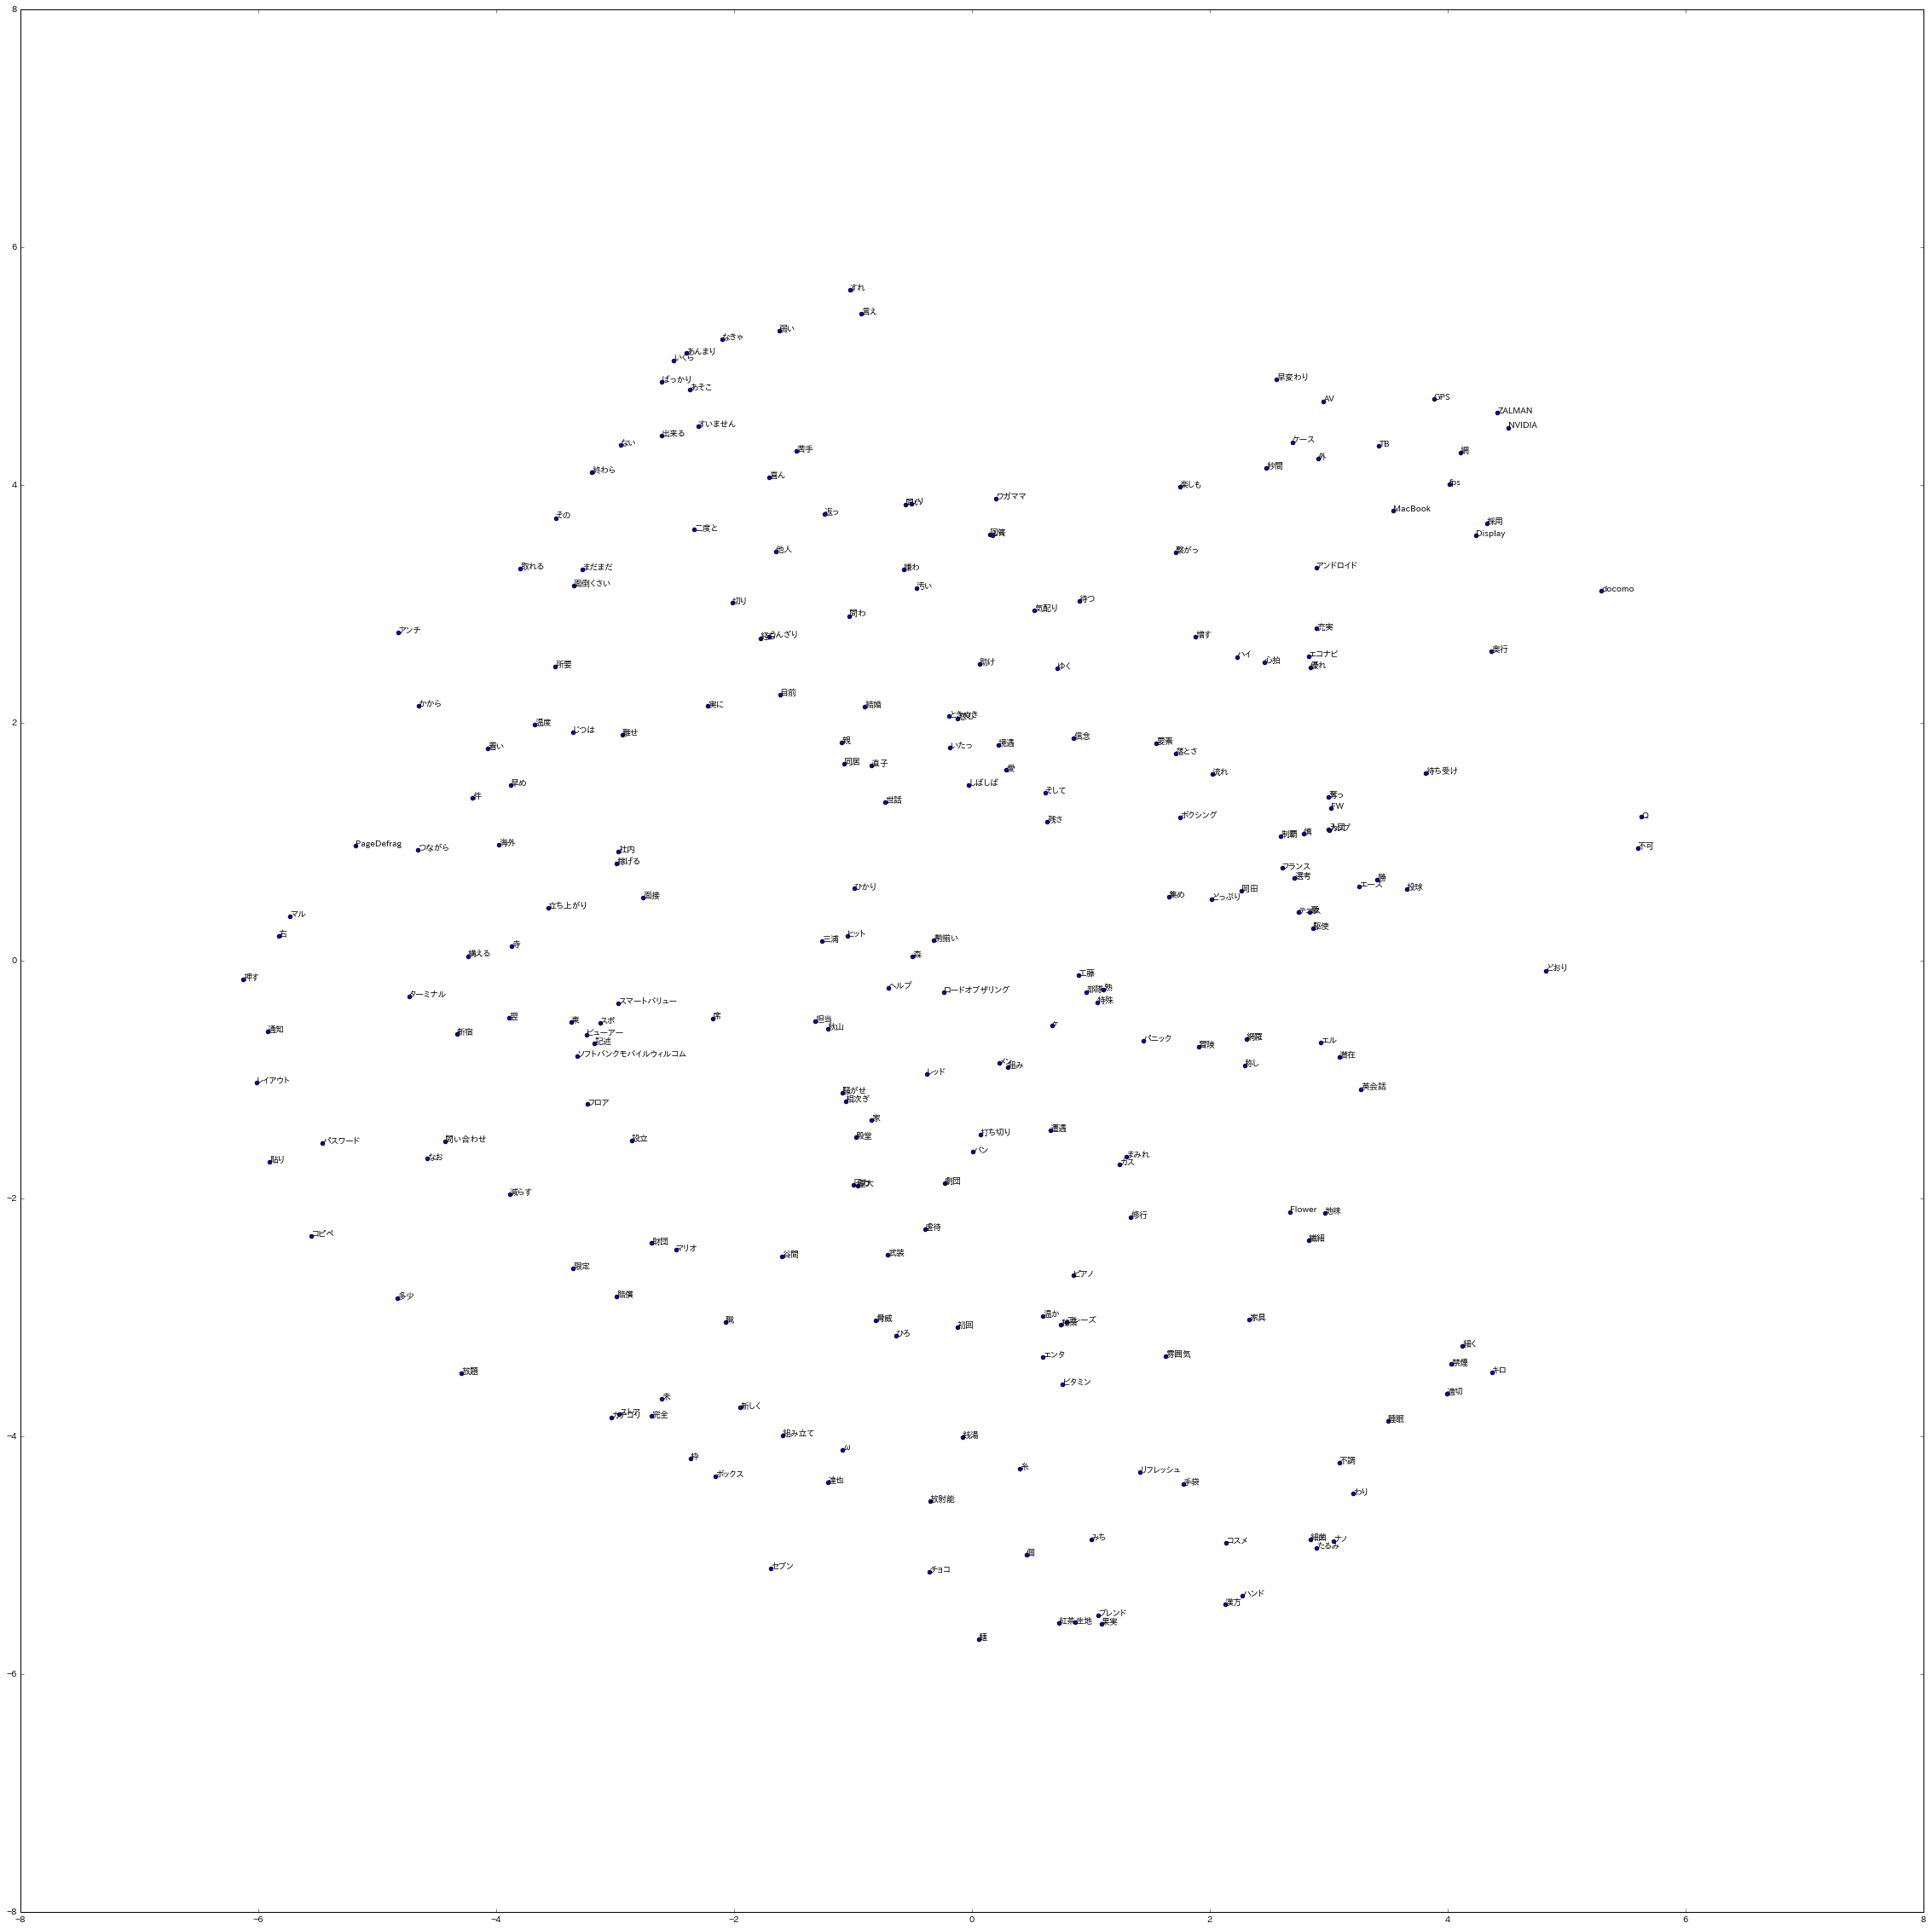

In [144]:
# plain word2vec t-SNE Visualization
word2vec_model=model
 
%matplotlib inline
import matplotlib.pyplot as plt 
from sklearn.manifold import TSNE
import numpy as np

skip=0
limit=241 

vocab = word2vec_model.wv.vocab
emb_tuple = tuple([word2vec_model[v] for v in vocab])
X = np.vstack(emb_tuple)
 
model = TSNE(n_components=2, random_state=0,verbose=2)
np.set_printoptions(suppress=True)
model.fit_transform(X) 

In [ ]:
# import plotly
# import plotly.plotly as py
# import plotly.graph_objs as go
# plotly.offline.init_notebook_mode(connected=False)
# # Create a trace
# trace = go.Scatter(
#     x =model.embedding_[skip:limit, 0],
#     y = model.embedding_[skip:limit, 1],
#     text=list(vocab.keys()),
#     mode = 'markers+text'
# )

# data = [trace]

# # Plot and embed in ipython notebook!
# plotly.offline.iplot(data)

In [155]:
## create gwbowv
from sklearn.feature_extraction.text import TfidfVectorizer,HashingVectorizer
import pickle
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [173]:
def drange(start, stop, step):
    r = start
    while r < stop:
        yield r
        r += step

def cluster_GMM(num_clusters, word_vectors):
    # Initalize a GMM object and use it for clustering.
    clf =  GaussianMixture(n_components=num_clusters,
                    covariance_type="tied", init_params='kmeans', max_iter=50)
    # Get cluster assignments.
    clf.fit(word_vectors)
    idx = clf.predict(word_vectors)
    print ("Clustering Done...", time.time()-start, "seconds")
    # Get probabilities of cluster assignments.
    idx_proba = clf.predict_proba(word_vectors)
    # Dump cluster assignments and probability of cluster assignments. 
    pickle.dump(idx, open('../japanese-dataset/livedoor-news-corpus/model/gmm_latestclusmodel_len2alldata.pkl',"wb"))
    print ("Cluster Assignments Saved...")

    pickle.dump(idx_proba,open( '../japanese-dataset/livedoor-news-corpus/model/gmm_prob_latestclusmodel_len2alldata.pkl',"wb"))
    print ("Probabilities of Cluster Assignments Saved...")
    return (idx, idx_proba)

def read_GMM(idx_name, idx_proba_name):
    # Loads cluster assignments and probability of cluster assignments. 
    idx = pickle.load(open('../japanese-dataset/livedoor-news-corpus/model/gmm_latestclusmodel_len2alldata.pkl',"rb"))
    idx_proba = pickle.load(open( '../japanese-dataset/livedoor-news-corpus/model/gmm_prob_latestclusmodel_len2alldata.pkl',"rb"))
    print ("Cluster Model Loaded...")
    return (idx, idx_proba)

def get_probability_word_vectors(featurenames, word_centroid_map, num_clusters, word_idf_dict):
    # This function computes probability word-cluster vectors
    prob_wordvecs = {}
    for word in word_centroid_map:
        prob_wordvecs[word] = np.zeros( num_clusters * num_features, dtype="float32" )
        for index in range(0, num_clusters):
            try:
                prob_wordvecs[word][index*num_features:(index+1)*num_features] = model[word] * word_centroid_prob_map[word][index] * word_idf_dict[word]
            except:
                continue

    # prob_wordvecs_idf_len2alldata = {}
    # i = 0
    # for word in featurenames:
    #     i += 1
    #     if word in word_centroid_map:    
    #         prob_wordvecs_idf_len2alldata[word] = {}
    #         for index in range(0, num_clusters):
    #                 prob_wordvecs_idf_len2alldata[word][index] = model[word] * word_centroid_prob_map[word][index] * word_idf_dict[word] 

    

    # for word in prob_wordvecs_idf_len2alldata.keys():
    #     prob_wordvecs[word] = prob_wordvecs_idf_len2alldata[word][0]
    #     for index in prob_wordvecs_idf_len2alldata[word].keys():
    #         if index==0:
    #             continue
    #         prob_wordvecs[word] = np.concatenate((prob_wordvecs[word], prob_wordvecs_idf_len2alldata[word][index]))
    return prob_wordvecs

def create_cluster_vector_and_gwbowv(prob_wordvecs, wordlist, word_centroid_map, word_centroid_prob_map, dimension, word_idf_dict, featurenames, num_centroids, train=False):
    # This function computes SDV feature vectors.
    bag_of_centroids = np.zeros( num_centroids * dimension, dtype="float32" )
    global min_no
    global max_no

    for word in wordlist:
        try:
            temp = word_centroid_map[word]
        except:
            continue

        bag_of_centroids += prob_wordvecs[word]

    norm = np.sqrt(np.einsum('...i,...i', bag_of_centroids, bag_of_centroids))
    if(norm!=0):
        bag_of_centroids /= norm

    # To make feature vector sparse, make note of minimum and maximum values.
    if train:
        min_no += min(bag_of_centroids)
        max_no += max(bag_of_centroids)

    return bag_of_centroids

In [159]:
num_features = 200     # Word vector dimensionality
min_word_count = 20   # Minimum word count
num_workers = 40       # Number of threads to run in parallel
context = 10          # Context window size
downsampling = 1e-3   # Downsample setting for frequent words

model_name = str(num_features) + "features_" + str(min_word_count) + "minwords_" + str(context) + "context_len2alldata"
# Load the trained Word2Vec model.
model = Word2Vec.load("../japanese-dataset/livedoor-news-corpus/model/"+model_name)
# Get wordvectors for all words in vocabulary.
word_vectors = model.wv.syn0

# Load train data.
train,test = train_test_split(df,test_size=0.3,random_state=40)
all = df

# Set number of clusters.
num_clusters = 60
# Uncomment below line for creating new clusters.
idx, idx_proba = cluster_GMM(num_clusters, word_vectors)

# Uncomment below lines for loading saved cluster assignments and probabaility of cluster assignments.
# idx_name = "gmm_latestclusmodel_len2alldata.pkl"
# idx_proba_name = "gmm_prob_latestclusmodel_len2alldata.pkl"
# idx, idx_proba = read_GMM(idx_name, idx_proba_name)

# Create a Word / Index dictionary, mapping each vocabulary word to
# a cluster number
word_centroid_map = dict(zip( model.wv.index2word, idx ))
# Create a Word / Probability of cluster assignment dictionary, mapping each vocabulary word to
# list of probabilities of cluster assignments.
word_centroid_prob_map = dict(zip( model.wv.index2word, idx_proba ))

/Users/fufufukakaka/.pyenv/versions/anaconda3-4.0.0/lib/python3.5/site-packages/sklearn/mixture/base.py:237: ConvergenceWarning:

Initialization 1 did not converged. Try different init parameters, or increase max_iter, tol or check for degenerate data.



Clustering Done... 17276.81133389473 seconds
Cluster Assignments Saved...
Probabilities of Cluster Assignments Saved...


In [168]:
# Computing tf-idf values.
traindata = []
for review in all["news"]:
    result = tokenizer.parse(review).replace("\u3000","").replace("\n","")
    result = re.sub(r'[0123456789０１２３４５６７８９！＠＃＄％＾＆\-|\\＊\“（）＿■×※⇒—●(：〜＋=)／*&^%$#@!~`){}…\[\]\"\'\”:;<>?＜＞？、。・,./『』【】「」→←○]+', "", result)
    h = result.split(" ")
    h = filter(("").__ne__, h)
    traindata.append(" ".join(h))

tfv = TfidfVectorizer(dtype=np.float32)
tfidfmatrix_traindata = tfv.fit_transform(traindata)
featurenames = tfv.get_feature_names()
idf = tfv._tfidf.idf_

# Creating a dictionary with word mapped to its idf value 
print ("Creating word-idf dictionary for Training set...")

word_idf_dict = {}
for pair in zip(featurenames, idf):
    word_idf_dict[pair[0]] = pair[1]
    
# Pre-computing probability word-cluster vectors.
prob_wordvecs = get_probability_word_vectors(featurenames, word_centroid_map, num_clusters, word_idf_dict)

Creating word-idf dictionary for Training set...


In [178]:
pickle.dump(prob_wordvecs,open("../japanese-dataset/livedoor-news-corpus/model/prob_wordvecs.pkl","wb"))

In [174]:
# gwbowv is a matrix which contains normalised document vectors.
gwbowv = np.zeros( (train["news"].size, num_clusters*(num_features)), dtype="float32")

counter = 0

min_no = 0
max_no = 0
for review in train["news"]:
    # Get the wordlist in each news article.
    result = tokenizer.parse(review).replace("\u3000","").replace("\n","")
    result = re.sub(r'[0123456789０１２３４５６７８９！＠＃＄％＾＆\-|\\＊\“（）＿■×※⇒—●(：〜＋=)／*&^%$#@!~`){}…\[\]\"\'\”:;<>?＜＞？、。・,./『』【】「」→←○]+', "", result)
    h = result.split(" ")
    h = filter(("").__ne__, h)
    words = h
    gwbowv[counter] = create_cluster_vector_and_gwbowv(prob_wordvecs, words, word_centroid_map, word_centroid_prob_map, num_features, word_idf_dict, featurenames, num_clusters, train=True)
    counter+=1
    if counter % 1000 == 0:
        print ("Train News Covered : ",counter)

gwbowv_name = "SDV_" + str(num_clusters) + "cluster_" + str(num_features) + "feature_matrix_gmm_sparse.npy"

gwbowv_test = np.zeros( (test["news"].size, num_clusters*(num_features)), dtype="float32")

counter = 0

for review in test["news"]:
    # Get the wordlist in each news article.
    result = tokenizer.parse(review).replace("\u3000","").replace("\n","")
    result = re.sub(r'[0123456789０１２３４５６７８９！＠＃＄％＾＆\-|\\＊\“（）＿■×※⇒—●(：〜＋=)／*&^%$#@!~`){}…\[\]\"\'\”:;<>?＜＞？、。・,./『』【】「」→←○]+', "", result)
    h = result.split(" ")
    h = filter(("").__ne__, h)
    words = h
    gwbowv_test[counter] = create_cluster_vector_and_gwbowv(prob_wordvecs, words, word_centroid_map, word_centroid_prob_map, num_features, word_idf_dict, featurenames, num_clusters)
    counter+=1
    if counter % 1000 == 0:
        print ("Test News Covered : ",counter)

test_gwbowv_name = "TEST_SDV_" + str(num_clusters) + "cluster_" + str(num_features) + "feature_matrix_gmm_sparse.npy"

print ("Making sparse...")
# Set the threshold percentage for making it sparse. 
percentage = 0.04
min_no = min_no*1.0/len(train["news"])
max_no = max_no*1.0/len(train["news"])
print ("Average min: ", min_no)
print ("Average max: ", max_no)
thres = (abs(max_no) + abs(min_no))/2
thres = thres*percentage

# Make values of matrices which are less than threshold to zero.
temp = abs(gwbowv) < thres
gwbowv[temp] = 0

temp = abs(gwbowv_test) < thres
gwbowv_test[temp] = 0

#saving gwbowv train and test matrices
np.save("../japanese-dataset/livedoor-news-corpus/model/"+gwbowv_name, gwbowv)
np.save("../japanese-dataset/livedoor-news-corpus/model/"+test_gwbowv_name, gwbowv_test)

Train News Covered :  1000
Train News Covered :  2000
Train News Covered :  3000
Train News Covered :  4000
Train News Covered :  5000
Test News Covered :  1000
Test News Covered :  2000
Making sparse...
Average min:  -0.122336335051
Average max:  0.125114067933


In [177]:
## plot modified word vector representation
skip=0
limit=241 

vocab = prob_wordvecs.keys()
emb_tuple = tuple([prob_wordvecs[v] for v in vocab])
X = np.vstack(emb_tuple)
 
model = TSNE(n_components=2, random_state=0,verbose=2)
np.set_printoptions(suppress=True)
model.fit_transform(X)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...


KeyboardInterrupt: 

In [ ]:
## test SVC
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb

param_grid = {
    'learning_rate': [0.01, 0.05,0.02, 0.03,0.04],
    'boosting_type' : ['gbdt',"dart"],
    'objective' : ['multiclass'],
    'n_estimators': [100]
}
scores = ['accuracy', 'recall_micro', 'f1_micro']
for score in scores:
    strt = time.time()
    print ("# Tuning hyper-parameters for", score, "\n")
    clf = RandomizedSearchCV(lgb.LGBMClassifier(silent=False), param_grid, cv=3, scoring= '%s' % score,verbose=2)
    clf.fit(gwbowv, train["class"])
    print ("Best parameters set found on development set:\n")
    print (clf.best_params_)
    print ("Best value for ", score, ":\n")
    print (clf.best_score_)
    Y_true, Y_pred  = test["class"], clf.predict(gwbowv_test)
    print ("Report")
    print (classification_report(Y_true, Y_pred, digits=6))
    print ("Accuracy: ",clf.score(gwbowv_test,test["class"]))
    print ("Time taken:", time.time() - strt, "\n")
endtime = time.time()
print ("Total time taken: ", endtime-start, "seconds.")

# Tuning hyper-parameters for accuracy 

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_estimators=100, learning_rate=0.01, objective=multiclass, boosting_type=gbdt 
[CV]  n_estimators=100, learning_rate=0.01, objective=multiclass, boosting_type=gbdt, total= 9.5min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  9.5min remaining:    0.0s


[CV] n_estimators=100, learning_rate=0.01, objective=multiclass, boosting_type=gbdt 
[CV]  n_estimators=100, learning_rate=0.01, objective=multiclass, boosting_type=gbdt, total= 9.9min
[CV] n_estimators=100, learning_rate=0.01, objective=multiclass, boosting_type=gbdt 
[CV]  n_estimators=100, learning_rate=0.01, objective=multiclass, boosting_type=gbdt, total=10.6min
[CV] n_estimators=100, learning_rate=0.05, objective=multiclass, boosting_type=gbdt 
[CV]  n_estimators=100, learning_rate=0.05, objective=multiclass, boosting_type=gbdt, total= 8.6min
[CV] n_estimators=100, learning_rate=0.05, objective=multiclass, boosting_type=gbdt 
